## Goals: try t-SNE on flow and mass cytometry datasets
Use both standard t-SNE settings as well as what was proposed in the Nature paper by Belkina et al. 

### Using csv file

In [2]:
import pandas as pd

# Load the dataset
file_path = "flow18_for_optsne.csv"
data = pd.read_csv(file_path)

# Check the data structure
print(data.head())

   Parameter_10__NIR-CD14-CD19  Parameter_11__BUV395-CD25  \
0                     1.294049                   1.372984   
1                     1.531053                   0.230975   
2                     1.316954                   0.404094   
3                     1.654891                   0.244251   
4                     1.791981                   0.159833   

   Parameter_12__BUV737-CD127  Parameter_13__BUV805-CD8  \
0                    1.150639                 -0.270981   
1                    0.130211                  0.669266   
2                    0.409589                 -0.679833   
3                    0.327706                 -0.392105   
4                    0.899491                 -0.572280   

   Parameter_15__PE-Va24  Parameter_18__PE-Cy7-gdTCR  Parameter_20__BV510-CD3  \
0              -0.026751                    0.473704                 0.884921   
1               0.128261                    1.025142                 0.078498   
2               0.012887           

In [3]:
# Shuffle the rows to ensure randomness
# set frac to a different value if you only want to sample from the dataset - do this for a start 
data = data.sample(frac=0.1).reset_index(drop=True)

# Extract numerical features (omit any non-numerical columns if present)
# I think this is not needed 
# features = data.select_dtypes(include="number").values

In [4]:
from openTSNE import TSNE
import matplotlib.pyplot as plt

# Initialize the t-SNE model
tsne = TSNE(n_jobs=-1, perplexity=30, metric="euclidean", random_state=12, verbose=True)

# Perform t-SNE
embedding = tsne.fit(data.to_numpy())

--------------------------------------------------------------------------------
TSNE(early_exaggeration=12, n_jobs=-1, random_state=12, verbose=True)
--------------------------------------------------------------------------------
===> Finding 90 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 53.28 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 6.06 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.02 seconds
===> Running optimization with exaggeration=12.00, lr=8333.50 for 250 iterations...
Iteration   50, KL divergence 6.2011, 50 iterations in 14.4452 sec
Iteration  100, KL divergence 6.0648, 50 iterations in 14.2287 sec
Iteration  150, KL divergence 6.0109, 50 iterations in 16.0256 sec
Iteration  200, KL divergence 5.9838, 50 iterations in 19.8570 sec
Iteration  250, KL divergence 5.9671, 50 iterations in 14.2388 sec
   --> Time elapsed: 78.80 seconds
===> Running optimization with exagge

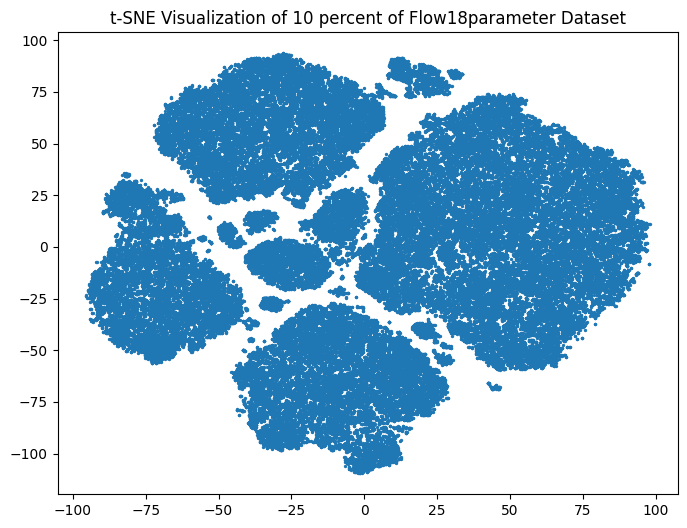

In [7]:
# Convert the embedding to a NumPy array for plotting
# embedding_array = embedding.embedding_

# Plot the results
plt.figure(figsize=(8, 6))
plt.scatter(embedding[:, 0], embedding[:, 1], s=2)
plt.title("t-SNE Visualization of 10 percent of Flow18parameter Dataset")
plt.show()

### Using fcs file and FlowCal library

In [6]:
import FlowCal

In [15]:
# Load the FCS file
file_path = 'flow18_annotated.fcs'  # Update with the correct file path

data = FlowCal.io.FCSData(file_path)
print("FCS file loaded successfully!")


FCS file loaded successfully!


Keep in mind: all cytometry data was transformed using asinh (with cofactor of 150 for flow14parameter) -> this has already been done for the flow18.fcs data!

11 lineage parameters used for embedding 

In [16]:
# Display basic information about the FCS data
print("Channels:", data.channels)  # Check channel names
print("Shape:", data.shape)  # Check the size of the dataset

Channels: ('Parameter_1', 'Parameter_10', 'Parameter_11', 'Parameter_12', 'Parameter_13', 'Parameter_14', 'Parameter_15', 'Parameter_16', 'Parameter_17', 'Parameter_18', 'Parameter_19', 'Parameter_2', 'Parameter_20', 'Parameter_21', 'Parameter_22', 'Parameter_23', 'Parameter_24', 'Parameter_3', 'Parameter_4', 'Parameter_5', 'Parameter_6', 'Parameter_7', 'Parameter_8', 'Parameter_9', 'SampleID', 'class')
Shape: (1000021, 26)


In [20]:
classes_channel_data = data[:, 'class']
print(classes_channel_data.text)

{'$FIL': 'concat_flow14_classes_1.fcs', '$TOT': '1000021', '$PAR': '26', '$BYTEORD': '4,3,2,1', '$DATATYPE': 'F', 'FJ_FCS_VERSION': '3', '$MODE': 'L', '$BEGINANALYSIS': '0', '$ENDANALYSIS': '0', '$BEGINSTEXT': '58', '$ENDSTEXT': '20048', '$COM': 'FlowJo LLC', '$NEXTDATA': '0', '$DATE': '6-26-2017', '$CYT': 'FlowJo TextToFCS v 1.3', '$P1S': 'Events', '$P2S': 'NIR-CD14-CD19', '$P3S': 'BUV395-CD25', '$P4S': 'BUV737-CD127', '$P5S': 'BUV805-CD8', '$P6S': 'Alexa-488-CD160', '$P7S': 'PE-Va24', '$P8S': 'PE-e610-LAG3', '$P9S': 'PerCP-e710-TIGIT', '$P10S': 'PE-Cy7-gdTCR', '$P11S': 'BV421-PD1', '$P12S': 'FSC-A', '$P13S': 'BV510-CD3', '$P14S': 'BV605-CD16', '$P15S': 'BV650-Tim3', '$P16S': 'BV786-CD56', '$P17S': 'index', '$P18S': 'FSC-H', '$P19S': 'FSC-W', '$P20S': 'SSC-A', '$P21S': 'SSC-H', '$P22S': 'SSC-W', '$P23S': 'APC-tet', '$P24S': 'Alexa-700-CD4', '$P1D': 'LIN,1.000000,1000000.000000', '$P2D': 'LIN,-0.666667,5.393939', '$P3D': 'LIN,-1.876543,8.000000', '$P4D': 'LIN,-3.345679,9.000000', '$P5D

## Trying out Flowkit library

In [21]:
import flowkit as fk
import pandas as pd 
import numpy as np 

In [30]:
sample = fk.Sample(data, sample_id='flow18', channel_labels=('Parameter_1', 'Parameter_10', 'Parameter_11', 'Parameter_12', 'Parameter_13', 'Parameter_14', 'Parameter_15', 'Parameter_16', 'Parameter_17', 'Parameter_18', 'Parameter_19', 'Parameter_2', 'Parameter_20', 'Parameter_21', 'Parameter_22', 'Parameter_23', 'Parameter_24', 'Parameter_3', 'Parameter_4', 'Parameter_5', 'Parameter_6', 'Parameter_7', 'Parameter_8', 'Parameter_9', 'SampleID', 'class'))
df_events = sample.as_dataframe(source="raw")
df_events.head()

pnn,Parameter_1,Parameter_10,Parameter_11,Parameter_12,Parameter_13,Parameter_14,Parameter_15,Parameter_16,Parameter_17,Parameter_18,...,Parameter_24,Parameter_3,Parameter_4,Parameter_5,Parameter_6,Parameter_7,Parameter_8,Parameter_9,SampleID,class
pns,,,,,,,,,,,...,,,,,,,,,,
0,93.0,1.294049,1.372984,1.150639,-0.270981,0.267041,-0.026751,0.161191,-0.058220,0.473704,...,93.0,77571.0,72488.703125,41004.00,37383.0,71883.960938,-0.161873,0.980540,18656.138672,1.0
1,131.0,1.531053,0.230975,0.130211,0.669266,0.137297,0.128261,0.050019,0.035314,1.025142,...,131.0,33060.0,70113.656250,13251.75,12656.0,68620.945312,0.033938,1.286410,19204.486328,1.0
2,211.0,1.316954,0.404094,0.409589,-0.679833,0.125787,0.012887,0.143312,0.093109,0.500123,...,211.0,51212.0,68854.312500,36941.25,33724.0,71788.085938,0.016212,0.980396,19148.910156,1.0
3,562.0,1.654891,0.244251,0.327706,-0.392105,0.040095,0.080716,-0.007977,-0.165906,0.502929,...,562.0,48061.0,72824.437500,19995.75,18617.0,70389.515625,-0.163500,1.025463,20557.527344,1.0
4,707.0,1.791981,0.159833,0.899491,-0.572280,0.673689,0.147960,0.175438,0.025739,0.802209,...,707.0,61107.0,70964.250000,30608.25,28615.0,70101.078125,-0.021349,1.194455,19987.566406,1.0


In [32]:
#TODO: filter data to only use classes that are also included in the csv file 
# Define the subset of columns to retain
selected_columns = [
    'Parameter_8', 'Parameter_9', 'Parameter_10', 'Parameter_11', 'Parameter_12', 
    'Parameter_13', 'Parameter_15', 'Parameter_18', 'Parameter_20', 
    'Parameter_21', 'Parameter_23', 'class'
]

# Filter the dataframe to include only the selected columns
df_filtered = df_events[selected_columns]

# Display the first few rows of the filtered dataframe
df_filtered.head()


pnn,Parameter_8,Parameter_9,Parameter_10,Parameter_11,Parameter_12,Parameter_13,Parameter_15,Parameter_18,Parameter_20,Parameter_21,Parameter_23,class
pns,,,,,,,,,,,,
0,-0.161873,0.980540,1.294049,1.372984,1.150639,-0.270981,-0.026751,0.473704,0.884921,0.189498,-0.395297,1.0
1,0.033938,1.286410,1.531053,0.230975,0.130211,0.669266,0.128261,1.025142,0.078498,-0.102181,-0.400954,1.0
2,0.016212,0.980396,1.316954,0.404094,0.409589,-0.679833,0.012887,0.500123,0.315362,0.279329,0.085067,1.0
3,-0.163500,1.025463,1.654891,0.244251,0.327706,-0.392105,0.080716,0.502929,0.451990,-0.143344,-0.179979,1.0
4,-0.021349,1.194455,1.791981,0.159833,0.899491,-0.572280,0.147960,0.802209,1.092266,1.146736,0.814916,1.0


In [33]:
#TODO: plot TSNE with correct labels 
from openTSNE import TSNE
import matplotlib.pyplot as plt

# Shuffle the rows to ensure randomness
# set frac to a different value if you only want to sample from the dataset - do this for a start 
data_sample = df_filtered.sample(frac=0.1).reset_index(drop=True)

# Separate features and labels
features = data_sample.drop(columns=['class'])  # All columns except 'class'
labels = data_sample['class']  # Only the 'class' column

# Initialize the t-SNE model
tsne = TSNE(n_jobs=-1, perplexity=30, metric="euclidean", random_state=12, verbose=True)
# Perform t-SNE
embedding = tsne.fit(features.to_numpy())

/var/folders/4d/3496lhrx28308spwb6q8gb800000gn/T/ipykernel_38995/2532316132.py:10: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  features = data_sample.drop(columns=['class'])  # All columns except 'class'


--------------------------------------------------------------------------------
TSNE(early_exaggeration=12, n_jobs=-1, random_state=12, verbose=True)
--------------------------------------------------------------------------------
===> Finding 90 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 63.87 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 7.64 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.12 seconds
===> Running optimization with exaggeration=12.00, lr=8333.50 for 250 iterations...
Iteration   50, KL divergence 6.2214, 50 iterations in 12.0586 sec
Iteration  100, KL divergence 6.0736, 50 iterations in 11.4182 sec
Iteration  150, KL divergence 6.0199, 50 iterations in 11.2158 sec
Iteration  200, KL divergence 5.9933, 50 iterations in 11.1417 sec
Iteration  250, KL divergence 5.9772, 50 iterations in 11.6606 sec
   --> Time elapsed: 57.50 seconds
===> Running optimization with exagge

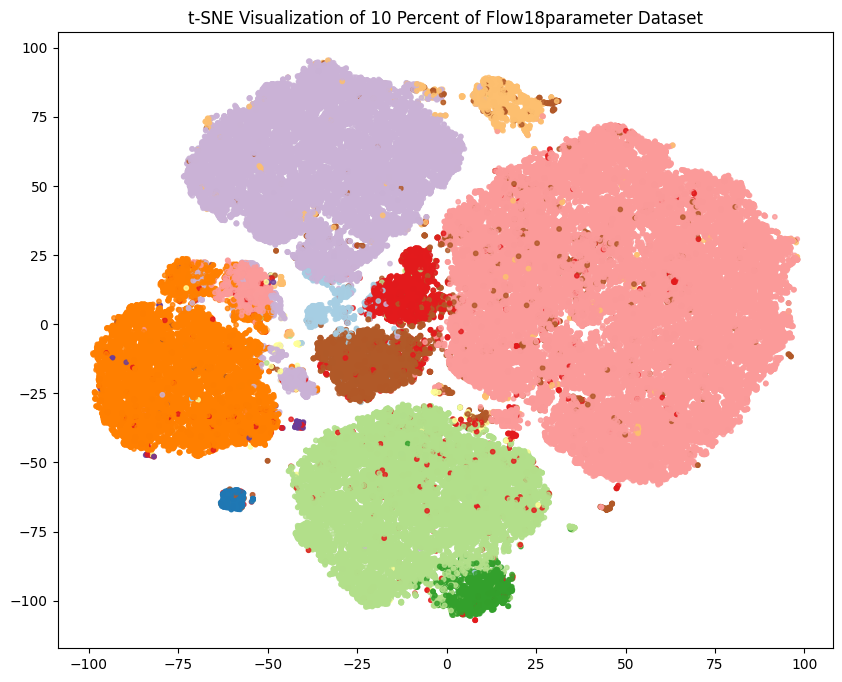

In [36]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=labels, cmap=plt.colormaps.get_cmap('Paired'), s=10, alpha=0.8)
# plt.colorbar(scatter, label='Class Label')
plt.title("t-SNE Visualization of 10 Percent of Flow18parameter Dataset")
# plt.xlabel("t-SNE Dimension 1")
# plt.ylabel("t-SNE Dimension 2")
plt.show()